In [1]:
import sys

import jax as jax

sys.path.append('..//')

import jax
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import jit
import time
import warnings

jax.config.update("jax_enable_x64", False)
jax.config.update("jax_platform_name", "gpu")

from parsmooth._base import MVNStandard, FunctionalModel, MVNSqrt
from parsmooth.linearization import cubature
from parsmooth.methods import iterated_smoothing
from tests.bearings.bearings_utils import make_parameters
from bearing_data import get_data

In [2]:
warnings.simplefilter("ignore")

In [3]:

s1 = jnp.array([-1.5, 0.5])  # First sensor location
s2 = jnp.array([1., 1.])  # Second sensor location
r = 0.5  # Observation noise (stddev)
x0 = jnp.array([0.1, 0.2, 1, 0])  # initial true location
dt = 0.01  # discretization time step
qc = 0.01  # discretization noise
qw = 0.1  # discretization noise

T = 5000
_, true_states, ys = get_data(x0, dt, r, T, s1, s2)
Q, R, observation_function, transition_function = make_parameters(qc, qw, r, dt, s1, s2)

chol_Q = jnp.linalg.cholesky(Q)
chol_R = jnp.linalg.cholesky(R)

m0 = jnp.array([-4., -1., 2., 7., 3.])
chol_P0 = jnp.eye(5)
P0 = jnp.eye(5)

init = MVNStandard(m0, P0)
chol_init = MVNSqrt(m0, chol_P0)

initial_states =  MVNStandard(jnp.repeat(jnp.array([[-1., -1., 6., 4., 2.]]),T + 1, axis=0),
                                                     jnp.repeat(jnp.eye(5).reshape(1, 5, 5), T + 1, axis=0))
initial_states_sqrt = MVNSqrt(jnp.repeat(jnp.array([[-1., -1., 6., 4., 2.]]),T + 1, axis=0),
                              jnp.repeat(jnp.eye(5).reshape(1, 5, 5), T + 1, axis=0))


sqrt_transition_model = FunctionalModel(transition_function, MVNSqrt(jnp.zeros((5,)), chol_Q))
transition_model = FunctionalModel(transition_function, MVNStandard(jnp.zeros((5,)), Q))

sqrt_observation_model = FunctionalModel(observation_function, MVNSqrt(jnp.zeros((2,)), chol_R))
observation_model = FunctionalModel(observation_function, MVNStandard(jnp.zeros((2,)), R))

In [4]:
def cubature_sqrt_seq(y, initial_points_sqrt, iteration):
    sqrt_seq_res = iterated_smoothing(y, chol_init, sqrt_transition_model, sqrt_observation_model,
                                      cubature, initial_points_sqrt, False,
                                      criterion=lambda i, *_: i < iteration)
    return sqrt_seq_res



In [5]:
def cubature_sqrt_par(y, initial_points_sqrt, iteration):
    sqrt_par_res = iterated_smoothing(y, chol_init, sqrt_transition_model, sqrt_observation_model,
                                      cubature, initial_points_sqrt, True,
                                      criterion=lambda i, *_: i < iteration)
    return sqrt_par_res



In [6]:
def func(method, lengths, n_runs=1, n_iter=10, sqrt=False):
    res_mean = []
    for k, j in enumerate(lengths):
        print(f"Iteration {k+1} out of {len(lengths)}", end="\r")
        observations_slice = ys[:j]
        
        if sqrt:
            init_linearizations_points_slice = initial_states_sqrt.mean[:j+1]
            init_linearizations_chols_slice = initial_states_sqrt.chol[:j+1]
            init_linearizations_states = MVNSqrt(init_linearizations_points_slice, init_linearizations_chols_slice)
            args = observations_slice, init_linearizations_states, n_iter
        else:
            init_linearizations_points_slice = initial_states.mean[:j+1]
            init_linearizations_covs_slice = initial_states.cov[:j+1]
            init_linearizations_states = MVNStandard(init_linearizations_points_slice, init_linearizations_covs_slice)
            args = observations_slice, init_linearizations_states, n_iter
            
        s = method(*args)                
        s.mean.block_until_ready()
        run_times = []
        for _ in range(n_runs):
            tic = time.time()
            s_states = method(*args)
            s_states.mean.block_until_ready()
            toc = time.time()
            run_times.append(toc - tic)
        res_mean.append(np.mean(run_times))
    print()
    return np.array(res_mean)

In [7]:
lengths_space = np.logspace(2, int(np.log2(T)), num=10, base=2, dtype=int)


In [8]:
gpu_cubature_sqrt_par = jit(cubature_sqrt_par, backend="gpu")
gpu_cubature_sqrt_seq = jit(cubature_sqrt_seq, backend="gpu")


In [9]:
warnings.filterwarnings("ignore")

gpu_cubature_sqrt_par_time = func(gpu_cubature_sqrt_par, lengths_space, sqrt=True)

Iteration 10 out of 10


In [10]:
warnings.filterwarnings("ignore")
gpu_cubature_sqrt_seq_time = func(gpu_cubature_sqrt_seq, lengths_space, sqrt = True)



KeyboardInterrupt: 

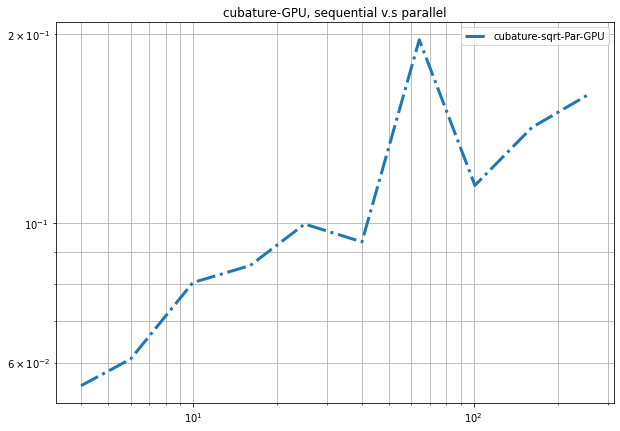

In [11]:
plt.figure(figsize=(10,7))
plt.loglog(lengths_space, gpu_cubature_sqrt_par_time, label="cubature-sqrt-Par-GPU", linestyle="-.", linewidth=3)
# plt.loglog(lengths_space, gpu_cubature_sqrt_seq_time, label="cubature-sqrt-Seq-GPU", linestyle="-.", linewidth=3)

plt.grid(True, which="both")
plt.title("cubature-GPU, sequential v.s parallel")
plt.legend()
plt.show()